In [1]:
import glob
import os
import re
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import rcParams

import nltk
import numpy as np
import pandas
import seaborn as sns
from nltk.util import ngrams

import helper
import scores

In [2]:
sns.set_context("paper", font_scale=1.2)
rcParams.update({'figure.autolayout': True})

GRAPHICS_DIR = "../report/graphics/"

train_set, train_wrd_tag, test_set, lex = helper.preprocess_files()

In [3]:
# load train_pos_set
train_pos_file = open("../P1_data/data/NLSPARQL.train.feats.txt",
                      "r", encoding="utf8").read()
train_pos_set = [[pair.split("\t")[:2] # only consider word and POS tag
                  for pair in sentence.split("\n")]
                 for sentence in train_pos_file.split("\n\n")]

In [4]:
# clean old graphics
for f in glob.glob(GRAPHICS_DIR + '*'):
    os.remove(f)

In [5]:
# and we also get a free pandas dataframe
df = scores.process_score_files()

df_only_iob  = df.loc[df["version"] == "iob"]
df_iob_and_w = df.loc[df["version"] == "iob_and_w"]
df_baseline  = df.loc[df["version"] == "Baseline"]

____

# Analysis of tags

In [6]:
def get_n_tags(dt):
    return len(set(p[1] for s in dt for p in s))

print(f"Amount of examples in training set: {len(train_set)}")
print(f"Amount of IOB tags: {get_n_tags(train_set)}")
print(f"Amount of IOB+W tags: {get_n_tags(train_wrd_tag)}")
print(f"Amount of POS tags: {get_n_tags(train_pos_set)}")

Amount of examples in training set: 3338
Amount of IOB tags: 41
Amount of IOB+W tags: 781
Amount of POS tags: 49


In [7]:
def barplot_frequencies(dt, name, mc=0, figsize=(9, 10), log_scale=""):

    fd = nltk.FreqDist([p[1] for s in dt for p in s])
    
    if mc > 0:
        dtrain_setf = pandas.DataFrame(fd.most_common(mc),
            columns = ["Tags", "Count"])
    else:
        dtrain_setf=pandas.DataFrame(
            sorted(list((w, fd.freq(w)) for w in fd.keys()),
                  key=lambda x: x[1], reverse=True),
            columns = ["Tags", "Count"])


    f, ax=plt.subplots(figsize = figsize)
#     plt.tight_layout()
    
    g=sns.barplot(data = dtrain_setf, x = "Count", y = "Tags")
    
    # To remove labels or set custom labels
#     ax.set_ylabel('')    
#     ax.set_xlabel('')
    
    if "x" in log_scale:
            ax.set(xscale="log")
    if "y" in log_scale:
            ax.set(yscale="log")

    g.get_figure().savefig(GRAPHICS_DIR + name + ".png", dpi=400, bbox_inches='tight')

D:\User\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


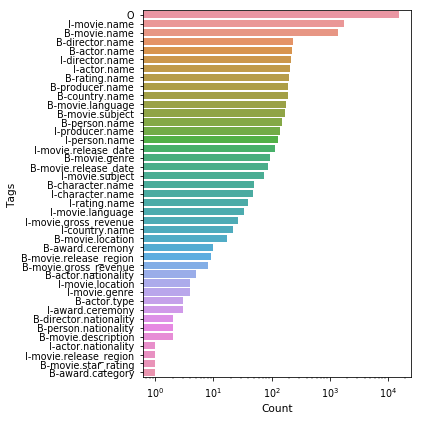

In [8]:
barplot_frequencies(train_set, "barplot_iob_tag_counts",
                    figsize=(6, 6), mc=42, log_scale="x")

D:\User\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


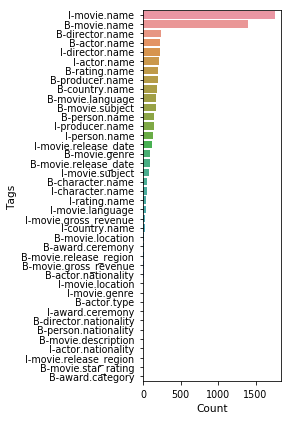

In [9]:
barplot_frequencies([[p for p in s if "O__" not in p[1]] for s in train_wrd_tag],
                    "barplot_iob&w_tag_counts_notO",
                    mc=60, 
                   figsize=(4.2,6))

D:\User\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


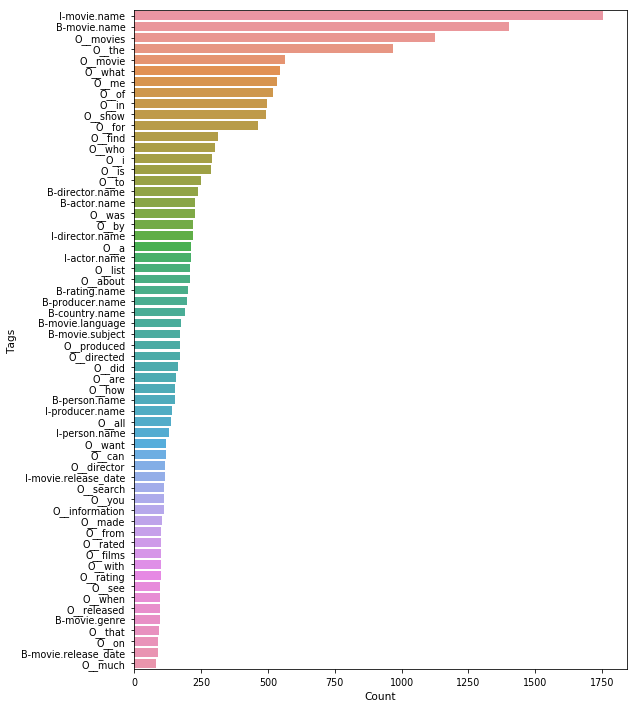

In [10]:
barplot_frequencies(train_wrd_tag, 
                    "barplot_iob&w_tag_counts", 
                    mc=60)

O__ barplot and word barplot, should be the same. Here we see the most common ones

D:\User\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


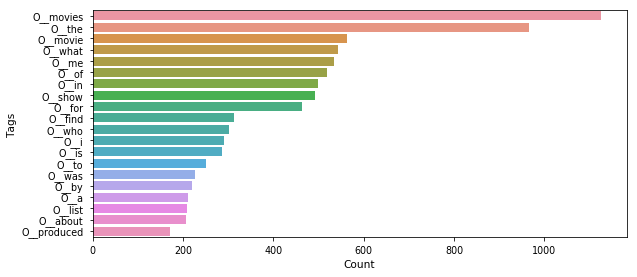

In [11]:
barplot_frequencies([[p for p in s if "O__" in p[1]] for s in train_wrd_tag],
                    "barplot_iob&w_tag_counts_onlyO",
                    mc=20,
                    figsize=(9,4))

D:\User\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


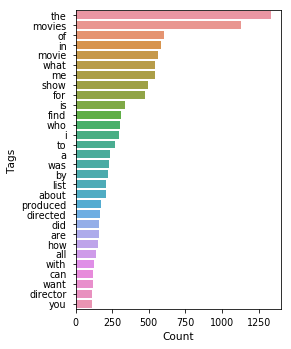

In [12]:
barplot_frequencies([[(p[1], p[0]) for p in s] for s in train_wrd_tag],
                    "barplot_iob&w_tag_counts_onlyW",
                    mc=30,
                    figsize=(4.2,5))

__________________________

## POS tags

D:\User\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


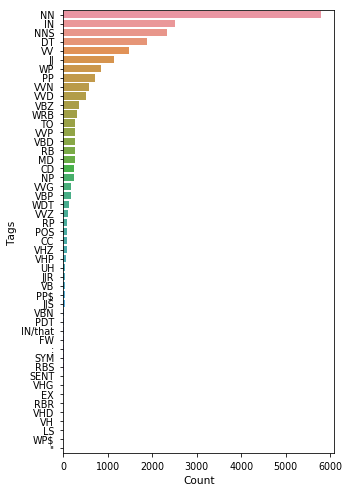

In [13]:
barplot_frequencies([[p for p in s] for s in train_pos_set],
                    "barplot_pos_counts",
                   figsize=(5,7), 
#                    log_scale="x", 
                   mc=100)

________________

# Scores

In [14]:
df_baseline

,version,method,order,FB1,accuracy,precision,recall
60,Baseline,None,1,57.07,88.82,54.76,59.58


D:\User\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


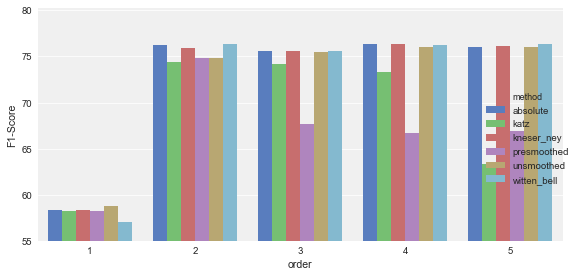

In [15]:
sns.set_style("darkgrid", {"axes.facecolor": ".94"})
g = sns.factorplot(data=df_only_iob, hue="method", x="order", 
                    y="FB1", kind="bar", palette="muted", aspect=1.7)
g.set_ylabels("F1-Score")
g.axes[0][0].set_ylim(bottom=55)

g.savefig(GRAPHICS_DIR + "f1-score_vs_order_by_method.png",  dpi=400)

In [23]:
def drw_score_heatmap(df, name):
    data_heatmap = df[["method", "order", "FB1"]].pivot("order", "method", "FB1")
#     cmap = sns.diverging_palette(200, 20, as_cmap=True)
    heatmap = sns.heatmap(data_heatmap, annot=True, linewidths=.5, fmt=".2f")
    heatmap.get_figure().savefig(GRAPHICS_DIR + name + ".png", dpi=400)

D:\User\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


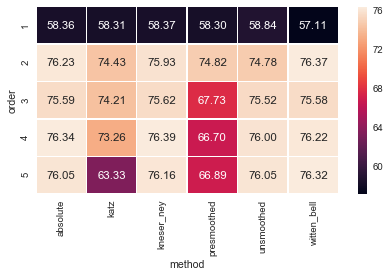

In [24]:
drw_score_heatmap(df_only_iob, "scores_heatmap_w2iob")

In [ ]:
df_only_iob.sort_values("FB1", ascending=False).head()

D:\User\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


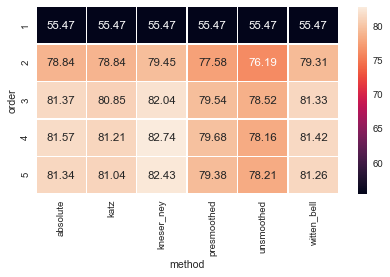

In [25]:
drw_score_heatmap(df_iob_and_w, "scores_heatmap_w2iob__w")

In [20]:
df_iob_and_w.sort_values("FB1", ascending=False).head()

,version,method,order,FB1,accuracy,precision,recall
43,iob_and_w,kneser_ney,4,82.74,94.96,82.44,83.04
44,iob_and_w,kneser_ney,5,82.43,94.91,82.09,82.77
42,iob_and_w,kneser_ney,3,82.04,94.84,81.60,82.49
33,iob_and_w,absolute,4,81.57,94.48,80.41,82.77
58,iob_and_w,witten_bell,4,81.42,94.42,80.12,82.77
